In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/wsb_processed.csv", index_col=0)

In [3]:
targets = ['score', 'comms_num', 'upvote_ratio']

df_features = df.drop(targets, axis=1)
df_targets = df[targets].drop('upvote_ratio', axis=1)

In [4]:
all_features = list(df_features.columns)

cont = ['title_length', 'title_capital', 'body_length', 'text_length', 'text_capital']
features = [str(x) for x in range(13)]
colors = [f'col{x}' for x in range(7)]
cont += features
cont += colors

cont_features = [f for f in all_features if f in cont]
rest_features = [f for f in all_features if f not in cont_features]

# Wybór zmiennej prognozowanej

In [5]:
df_targets.describe()

score     comms_num
count   38908.000000  38908.000000
mean     1067.872725    163.334456
std      8307.818756   2618.259934
min         0.000000      0.000000
25%         7.000000      2.000000
50%        22.000000      7.000000
75%       102.000000     23.000000
max    403161.000000  97996.000000

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
pca = PCA(n_components=1)

scaled_df = scaler.fit_transform(df_targets)

res = pca.fit_transform(scaled_df)

In [7]:
df_targets['principal'] = res

In [8]:
df_targets.describe()

score     comms_num     principal
count   38908.000000  38908.000000  3.890800e+04
mean     1067.872725    163.334456 -8.481651e-17
std      8307.818756   2618.259934  1.088988e+00
min         0.000000      0.000000 -1.350033e-01
25%         7.000000      2.000000 -1.334124e-01
50%        22.000000      7.000000 -1.310406e-01
75%       102.000000     23.000000 -1.194291e-01
max    403161.000000  97996.000000  3.752251e+01

In [9]:
df_targets['popularity'] = (df_targets['comms_num'] * 4 + df_targets['score']) / 2

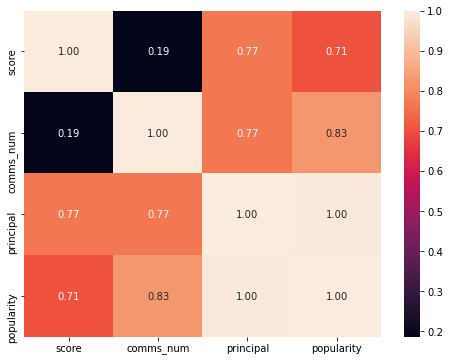

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_targets.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

# Linearity

In [11]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [12]:
regressor = LinearRegression()

In [13]:
numeric_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, cont_features),
    ('cat', cat_transformer, rest_features)
])

In [14]:
for target in df_targets.columns:
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])
    pipeline.fit(df_features, df_targets[target])
    r2 = r2_score(pipeline.named_steps['model'].predict(df_features), df_targets[target])
    mae = mean_absolute_error(pipeline.named_steps['model'].predict(df_features), df_targets[target])
    mse = mean_squared_error(pipeline.named_steps['model'].predict(df_features), df_targets[target])
    print(f"Target: {target} | R2: {r2} | MAE: {mae} | MSE: {mse}")

Target: score | R2: -0.06300618461097818 | MAE: 52077.5155084697 | MSE: 12417931877.03309
Target: comms_num | R2: -0.2730027401155335 | MAE: 3070.91347779619 | MSE: 53867488.18645884
Target: principal | R2: -0.04774394655839842 | MAE: 4.28531809235862 | MSE: 75.02163312175311
Target: popularity | R2: -0.04618071580287397 | MAE: 25037.24057901964 | MSE: 2499104086.9753785


# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeRegressor

df_norm = df_features.replace({0: -1, False: -1, True: 1})

parameters = {
    'max_depth': [10, 30, 50, 100], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1,2,5], 
    'max_features': ['auto', 'sqrt', None]}

models = dict()

for target in df_targets.columns:
    tree = DecisionTreeRegressor()
    
    clf = GridSearchCV(tree, parameters, cv=5)

    X_train, X_test, y_train, y_test = train_test_split(df_norm, df_targets[target], 
                                                        test_size=0.2, random_state=42, shuffle=True)

    clf.fit(X_train, y_train)
    
    print(f"Best: {clf.best_params_}")
    
    best = clf.best_estimator_
    models[target] = best
    
    r2 = clf.score(X_test, y_test)
    mae = mean_absolute_error(y_test, best.predict(X_test))
    mse = mean_squared_error(y_test, best.predict(X_test))
    
    print(f"Target: {target} | R2: {r2} | MAE: {mae} | MSE: {mse}")

Best: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
Target: score | R2: -0.14652279862501327 | MAE: 1767.9206989924012 | MSE: 56362068.676785015
Best: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Target: comms_num | R2: 0.291699225824667 | MAE: 229.0195078808926 | MSE: 5987361.117264894
Best: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Target: principal | R2: 0.20851636832021192 | MAE: 0.20539995308040304 | MSE: 0.8794678308785138
Best: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
Target: popularity | R2: 0.13222321691007022 | MAE: 1407.528589474304 | MSE: 45234035.99656184


# Shap

In [23]:
import shap

explainer = shap.Explainer(models['comms_num'])
shap_values = explainer(X_test[:1000])

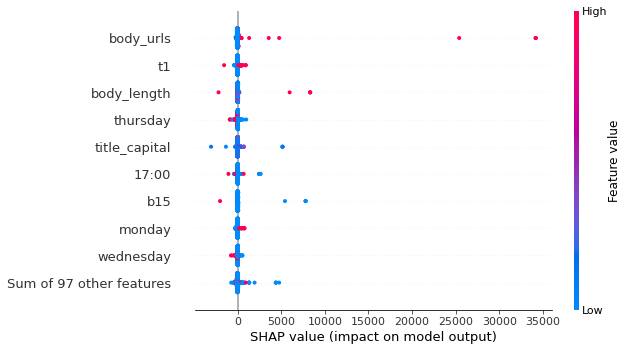

In [24]:
shap.plots.beeswarm(shap_values)

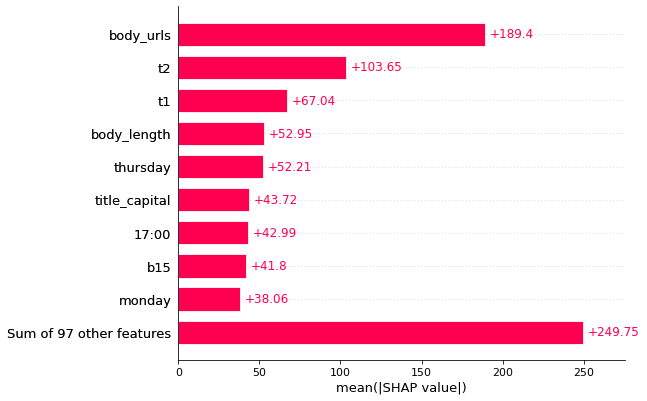

In [25]:
shap.plots.bar(shap_values)

# Neural network

In [31]:
import torch
import torch.nn as nn

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()

from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(df_norm, df_targets['comms_num'], 
                                                        test_size=0.2, random_state=42, shuffle=True)

X_train.loc[:, cont_features] = scaler.fit_transform(X_train[cont_features].copy())
X_test.loc[:, cont_features] = scaler.transform(X_test[cont_features].copy())

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

tensor_train_x = torch.Tensor(X_train.values)
tensor_train_y = torch.Tensor(y_train)

train_dataset = TensorDataset(tensor_train_x, tensor_train_y)

tensor_x = torch.Tensor(X_test.values)
tensor_y = torch.Tensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
class Model(nn.Module):
    def __init__(self, in_sz, out_sz, layers, p=0.5):
        super().__init__()
        
        layerlist = []
        
        for i in layers:
            layerlist.append(nn.Linear(in_sz, i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            in_sz = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x):
        x = self.layers(x)
        return x

In [33]:
model = Model(tensor_x.shape[1], 1, [1000, 100, 10], p=0.4)

model

Model(
  (layers): Sequential(
    (0): Linear(in_features=106, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1000, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=10, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [34]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
from tqdm.notebook import tqdm

epochs = 100
losses = []

for i in range(epochs):
    batch_loss = 0.0
    for X, y in tqdm(train_dataloader):
        y_pred = model(X)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item()
    
    if (i+1) % 100 == 0:
        torch.save(model.state_dict(), 'backup/nn_comms_checkpoint.pth')

    losses.append(batch_loss)
    print(f"Epoch {i+1}, loss: {batch_loss}")


Epoch 1, loss: 4.261827145004645



Epoch 2, loss: 0.5141432462260127



Epoch 3, loss: 0.5539610711857677



Epoch 4, loss: 0.46017085562925786



Epoch 5, loss: 0.4441981038544327



Epoch 6, loss: 0.38421555975219235



Epoch 7, loss: 0.3907207589945756



Epoch 8, loss: 0.3871795367449522



Epoch 9, loss: 0.35116945864865556



Epoch 10, loss: 0.3923442008672282



Epoch 11, loss: 0.3409848732990213



Epoch 12, loss: 0.34656963450834155



Epoch 13, loss: 0.35250784759409726



Epoch 14, loss: 0.3254447169601917



Epoch 15, loss: 0.3110638749494683



Epoch 16, loss: 0.35431662169867195



Epoch 17, loss: 0.31628351064864546



Epoch 18, loss: 0.3006978803605307



Epoch 19, loss: 0.3698078650049865



Epoch 20, loss: 0.3169597957166843



Epoch 21, loss: 0.32549116970039904



Epoch 22, loss: 0.3144164186087437



Epoch 23, loss: 0.3450331577914767



Epoch 24, loss: 0.312970201310236



Epoch 25, loss: 0.3297968215774745



Epoch 26, loss: 0.32802919117966667



Epoch 27, loss: 0.3605007663136348



Epoch 28, loss: 0.31600964537938125



Epoch 29, loss: 0.31886919715907425



Epoch 30, loss: 0.28604736615670845



Epoch 31, loss: 0.3143234012823086



Epoch 32, loss: 0.30911094005568884



Epoch 33, loss: 0.310080798342824



Epoch 34, loss: 0.317347995005548



Epoch 35, loss: 0.2980587051715702



Epoch 36, loss: 0.3500521237729117



Epoch 37, loss: 0.3305663293285761



Epoch 38, loss: 0.34935088717611507



Epoch 39, loss: 0.3149268155102618



Epoch 40, loss: 0.32508787943515927



Epoch 41, loss: 0.30336032732157037



Epoch 42, loss: 0.3228020827518776



Epoch 43, loss: 0.3219263679930009



Epoch 44, loss: 0.29860872065182775



Epoch 45, loss: 0.30925300176022574



Epoch 46, loss: 0.29290489037521183



Epoch 47, loss: 0.33727747527882457



Epoch 48, loss: 0.2977400707604829



Epoch 49, loss: 0.34073675458785146



Epoch 50, loss: 0.32564405575976707



Epoch 51, loss: 0.31444338453002274



Epoch 52, loss: 0.3068947237334214



Epoch 53, loss: 0.3081766054092441



Epoch 54, loss: 0.3193065265950281



Epoch 55, loss: 0.30629168925224803



Epoch 56, loss: 0.32363409860408865



Epoch 57, loss: 0.32044972412404604



Epoch 58, loss: 0.26641676743747666



Epoch 59, loss: 0.29974686732748523



Epoch 60, loss: 0.30094727216055617



Epoch 61, loss: 0.33536224011913873



Epoch 62, loss: 0.3048966962378472



Epoch 63, loss: 0.31077825697138906



Epoch 64, loss: 0.3220692104077898



Epoch 65, loss: 0.281669298739871



Epoch 66, loss: 0.30916014866670594



Epoch 67, loss: 0.2985146139981225



Epoch 68, loss: 0.31390373199246824



Epoch 69, loss: 0.31414586401660927



Epoch 70, loss: 0.29621632827911526



Epoch 71, loss: 0.3123633640061598



Epoch 72, loss: 0.3105310993560124



Epoch 73, loss: 0.31471390204387717



Epoch 74, loss: 0.3201003320282325



Epoch 75, loss: 0.30692837946116924



Epoch 76, loss: 0.293008235108573



Epoch 77, loss: 0.3310544505948201



Epoch 78, loss: 0.3148727735679131



Epoch 79, loss: 0.3238367135054432



Epoch 80, loss: 0.31260259021655656



Epoch 81, loss: 0.30518257041694596



Epoch 82, loss: 0.31141950280289166



Epoch 83, loss: 0.35408316628308967



Epoch 84, loss: 0.3233412695117295



Epoch 85, loss: 0.30422911752248183



Epoch 86, loss: 0.28672544099390507



Epoch 87, loss: 0.32483801583293825



Epoch 88, loss: 0.3443212606944144



Epoch 89, loss: 0.31598341211793013



Epoch 90, loss: 0.3061603537062183



Epoch 91, loss: 0.3081387408601586



Epoch 92, loss: 0.315130737493746



Epoch 93, loss: 0.30581350886495784



Epoch 94, loss: 0.3123378583113663



Epoch 95, loss: 0.26456130066071637



Epoch 96, loss: 0.2909309414390009



Epoch 97, loss: 0.3051584742497653



Epoch 98, loss: 0.30748148332349956



Epoch 99, loss: 0.3058465900539886



Epoch 100, loss: 0.30580068469862454


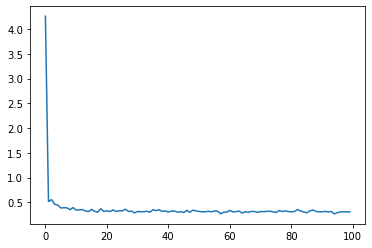

In [36]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [37]:
torch.save(model.state_dict(), 'backup/nn_comms_checkpoint.pth')

In [60]:
import numpy as np

model.eval()

with torch.no_grad():
    test_loss = []
    for X, y in tqdm(test_dataloader):
        y_val = model(X)
        loss = criterion(y_val, y)
        test_loss.append(loss.item())
print(f'RMSE: {np.mean(test_loss):.8f}')


RMSE: 0.00268001


In [61]:
X = df_targets['comms_num']

err = torch.mean(loss) * (X.max(axis=0) - X.min(axis=0)) + X.min(axis=0)

err.item()

130.291015625

# Shap

In [62]:
import numpy as np
import shap

#batch_bg = next(iter(test_dataloader))
#background, _ = batch_bg
background = torch.tensor(X_train.values[:1000], dtype=torch.float32)

explain = torch.tensor(X_test.values[:1000], dtype=torch.float32)

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(explain)

shap.initjs()

In [63]:
shap.plots.force(explainer.expected_value, shap_values, np.asarray(list(X_train.columns)))

## Wiedza
#### 1. Wtorki +
#### 2. Słowo "Sell" w title (t6) +
#### 3. Słowo "Stop" w body (b22) -
#### 4. Posty o 18 +